# Detection of ArUco Markers

Source [here]

[here]: https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html

## 1. Generating ArUco Markers

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
from skimage import io
from PIL import Image
from scripts.cv2_imshow import cv2_imshow

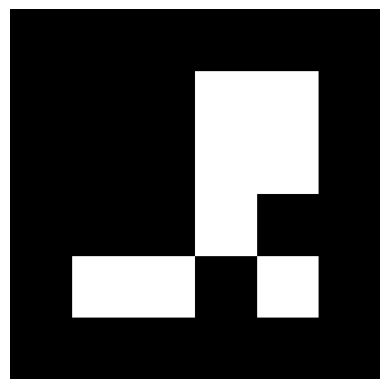

In [12]:
myDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)

def generate_aruco(id, dictionary=cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50), size=500, filename='aruco.png'):
    # Generate the marker image
    img = cv2.aruco.generateImageMarker(dictionary, id, size)
    cv2.imwrite(f'img/{filename}', img)
    return img

# Generate ArUco tag with id 2
tag_1 = generate_aruco(2, dictionary=myDict, filename='aruco_2.png')

# Display the image
cv2_imshow(tag_1)

## 1. Detecting Markers

Next step is to detect the tags on an input image

<img src="img/ArUco_test_1.png" width="500">

In [13]:
# load the image
test_1 = cv2.imread('img/ArUco_test_1.png')

markerIds = np.array([])

markerCorners = np.array([])
rejectedCandidates = np.array([])

detector = cv2.aruco.ArucoDetector(myDict, detectorParams=cv2.aruco.DetectorParameters())
markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(test_1, markerCorners, markerIds, rejectedCandidates)

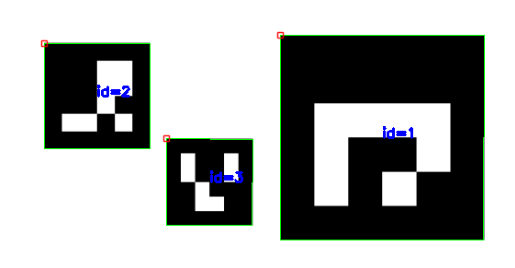

In [14]:
output_1 = test_1.copy()
output_1 = cv2.aruco.drawDetectedMarkers(output_1, markerCorners, markerIds, borderColor=(0, 255, 0))

cv2_imshow(output_1)

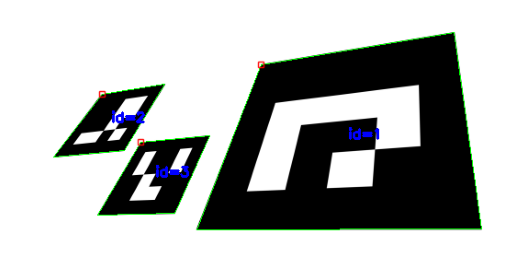

In [15]:
test_2 = cv2.imread('img/ArUco_test_2.png')
markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(test_2)

output_2 = test_2.copy()
output_2 = cv2.aruco.drawDetectedMarkers(output_2, markerCorners, markerIds, borderColor=(0, 255, 0))

cv2_imshow(output_2)

## 3. Pose Estimation

### a. Get to know camera parameters

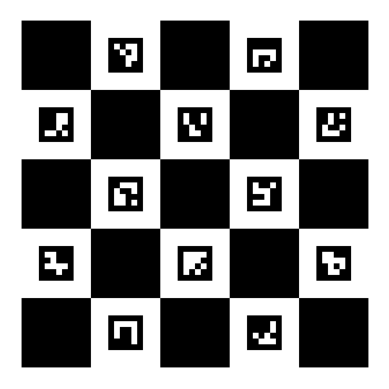

In [16]:
# Create a Charuco board
# taken from https://medium.com/@ed.twomey1/using-charuco-boards-in-opencv-237d8bc9e40d

# ------------------------------
# ENTER YOUR PARAMETERS HERE:
SQUARES_VERTICALLY = 5
SQUARES_HORIZONTALLY = 5
SQUARE_LENGTH = 0.03
MARKER_LENGTH = 0.015
LENGTH_PX = 640   # total length of the page in pixels
MARGIN_PX = 20    # size of the margin in pixels
SAVE_NAME = 'charuco_board.png'
# ------------------------------

def create_new_board():
    dictionary = myDict
    board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
    size_ratio = SQUARES_HORIZONTALLY / SQUARES_VERTICALLY
    img = cv2.aruco.CharucoBoard.generateImage(board, (LENGTH_PX, int(LENGTH_PX*size_ratio)), marginSize=MARGIN_PX)
    cv2.imwrite(f'img/{SAVE_NAME}', img)
    cv2_imshow(img)
    return board
    

charuco_board = create_new_board()

In [17]:
imgs = [cv2.imread(f'img/blender-captures/camera-calib-0{i}.png') for i in range(1, 5)]
gray = any

board_detector = cv2.aruco.CharucoDetector(charuco_board)
allCorners = []
allIds = []
allImgPoints = []
allObjPoints = []

for img in imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, ids, _, _ = board_detector.detectBoard(gray)
    objPoints, imgPoints =  charuco_board.matchImagePoints(corners, ids)
    
    if ids is not None:
        allCorners.append(corners[0])
        allIds.append(ids)
        allImgPoints.append(imgPoints)
        allObjPoints.append(objPoints)
        
allCorners = np.array(allCorners)
allIds = np.array(allIds)
allImgPoints = np.array(allImgPoints)
allObjPoints = np.array(allObjPoints)

cameraMatrix, distCoeffs = np.array([]), np.array([])
rvecs, tvecs = np.array([]), np.array([])

_, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(allObjPoints, allImgPoints, gray.shape[::-1], cameraMatrix, distCoeffs, rvecs, tvecs)
print(cameraMatrix)

[[1.77890156e+03 0.00000000e+00 6.41587993e+02]
 [0.00000000e+00 1.77893149e+03 3.59781829e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [21]:
distCoeffs

array([[-1.57242482e-02],
       [ 8.11030465e-01],
       [-1.33203106e-04],
       [ 3.48727350e-04],
       [-3.01644643e-01]])

In [18]:
# Save the camera matrix and distortion coefficients
np.savez('scripts/calibration.npz', cameraMatrix=cameraMatrix, distCoeffs=distCoeffs)

### b. Estimate pose

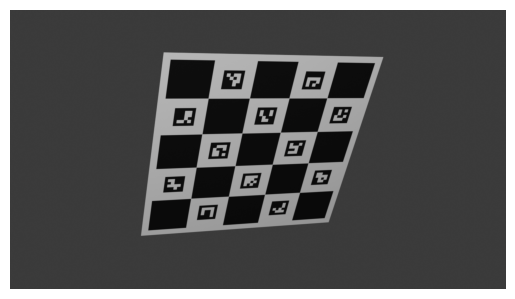

In [19]:
cv2_imshow(imgs[0])

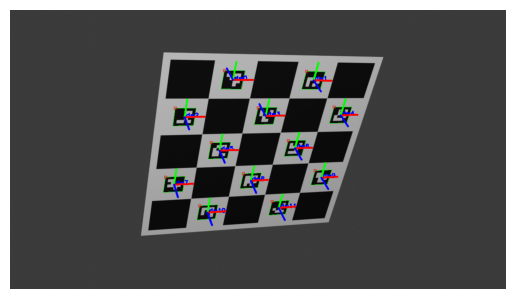

In [20]:
corners, ids, rejected = detector.detectMarkers(imgs[0])
output = imgs[0].copy()
output = cv2.aruco.drawDetectedMarkers(output, corners, ids, borderColor=(0, 255, 0))

for i in range(len(ids)):
    rvec, tvec, _ = cv2.aruco.estimatePoseSingleMarkers(corners[i], MARKER_LENGTH, cameraMatrix, distCoeffs)
    output = cv2.drawFrameAxes(output, cameraMatrix, distCoeffs, rvec, tvec, MARKER_LENGTH)

cv2_imshow(output)